In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: ', device)

Current device:  cuda


In [16]:
from torchvision.transforms.transforms import Compose, ToTensor, Resize, Normalize

def load_image(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

loader = Compose([Resize((356, 356)), ToTensor()])

original_img = load_image('/content/drive/MyDrive/Colab Notebooks/Internship/Neural Style Transfer/og_img.png')
style_img = load_image('/content/drive/MyDrive/Colab Notebooks/Internship/Neural Style Transfer/style_img.jpg')

In [17]:
vgg19_model = vgg19(pretrained=True).features
vgg19_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [18]:
"""
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
"""

class ModifiedVGG(nn.Module):
    def __init__(self):
        super(ModifiedVGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

vgg19_model = ModifiedVGG().to(device).eval()
generated_img = original_img.clone().requires_grad_(True)

In [19]:
total_steps = 6000
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated_img], lr=0.01)

for step in range(total_steps):
    generated_features = vgg19_model(generated_img)
    original_img_features = vgg19_model(original_img)
    style_features = vgg19_model(style_img)

    style_loss = original_loss = 0
    for gen_feature, orig_feature, style_feature in zip( generated_features, original_img_features, style_features):
        batch_size, channel, height, width = gen_feature.shape

        original_loss += torch.mean((gen_feature - orig_feature)**2)

        G = gen_feature.view (channel, height*width).mm(gen_feature.view(channel, height*width).t())
        A = style_feature.view (channel, height*width).mm(style_feature.view(channel, height*width).t())

        style_loss += torch.mean((G - A)**2)

    total_loss = alpha*original_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated_img, "generated_img.png")

tensor(61563.7500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2340.3379, device='cuda:0', grad_fn=<AddBackward0>)
tensor(895.0154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(546.4160, device='cuda:0', grad_fn=<AddBackward0>)
tensor(470.4816, device='cuda:0', grad_fn=<AddBackward0>)
tensor(361.4311, device='cuda:0', grad_fn=<AddBackward0>)
tensor(295.8875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(252.4191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(212.7894, device='cuda:0', grad_fn=<AddBackward0>)
tensor(767.2409, device='cuda:0', grad_fn=<AddBackward0>)
tensor(203.1740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(171.2704, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

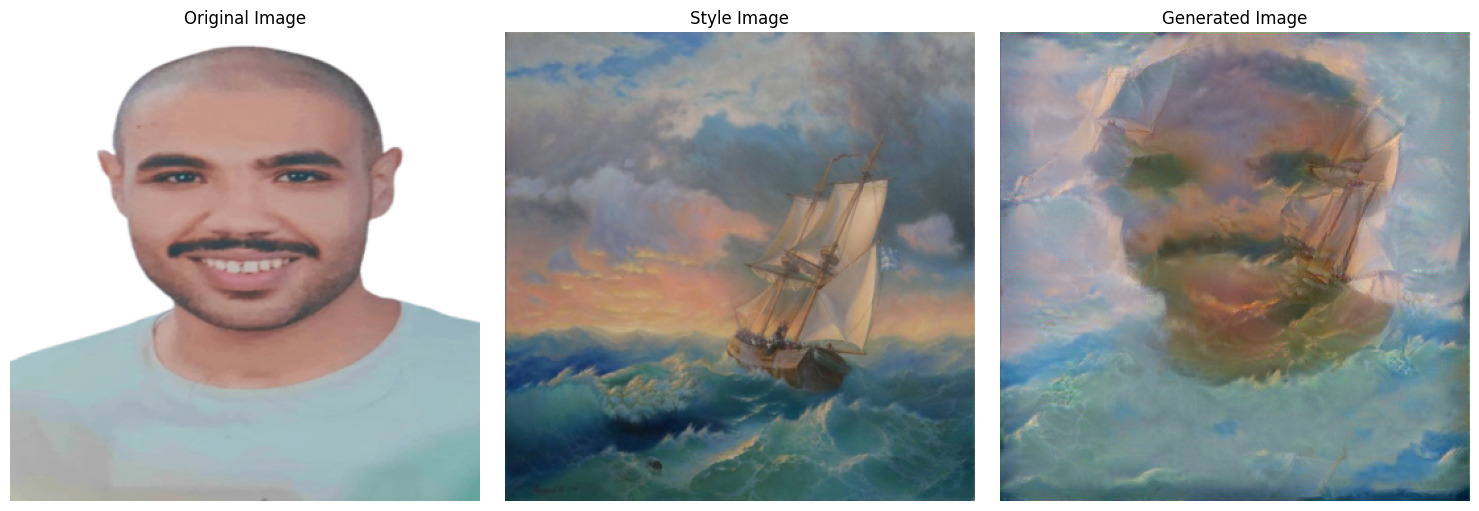

In [24]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.transpose(original_img.cpu().detach().numpy()[0], (1,2,0)))
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(np.transpose(style_img.cpu().detach().numpy()[0], (1,2,0)))
ax[1].set_title('Style Image')
ax[1].axis('off')

ax[2].imshow(np.transpose(generated_img.cpu().detach().numpy()[0], (1,2,0)))
ax[2].set_title('Generated Image')
ax[2].axis('off')

fig.tight_layout()

In [ ]:
# prompt: Describe the project

# This code implements a neural style transfer algorithm.
# It takes an original image and a style image as input, and generates a new image that combines the content of the original image with the style of the style image.

# The code uses the following steps:
# 1. Load the original and style images.
# 2. Define a modified VGG19 model that extracts features from the image.
# 3. Define the loss function, which is a combination of content loss and style loss.
# 4. Optimize the generated image to minimize the loss function.
# 5. Display the original, style, and generated images.


